In [1]:
import pandas
import pathlib
from matplotlib import pyplot as plt
from config import datadir

import scipy.optimize
import numpy
from tbcontrol.responses import fopdt, sopdt

In [2]:
excel_directory = pandas.read_excel(datadir/'Data Description.xlsx', parse_dates=True, index_col='Start Date') #Loads complete excel directory used to organise datasets
excel_directory

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Raw,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Raw,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe drift, performed inside t..."
2019-12-17,2019-12-23,pH Probe,Raw,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe Drift, circulating ph7 bu..."
2020-01-16,2020-01-16,pH Probe,Raw,Step Test,20200116 pH Step 3.txt,3,pH stepped outside of rig
2020-01-14,2020-01-14,pH Probe,Raw,Step Test,20200114 pH Step 1.broken,1,"pH stepped outside of rig. Probe Broke, Dump run"
2020-01-15,2020-01-15,pH Probe,Raw,Step Test,20200115 pH Step 2.txt,2,pH stepped outside of rig
2020-01-01,2020-01-01,Pumps,Calibration,Calibration,Pump Calibration.xlsx,1,Calibration data for all pumps
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.csv,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.csv,2,"long run of pH probe drift, performed inside t..."


In [3]:
steps = excel_directory[(excel_directory['Type']=='Step Test')]    # Creates a new directory of only the raw data files to be cleaned 
                                                            # Use '&' for multiple conditions

In [4]:
external_steps = pandas.read_csv(datadir /'20200115 pH Step 2.csv')
external_steps

,DateTime,Temp,pH
0,2020-01-15 11:59:11,293.801689,7.074204
1,2020-01-15 11:59:12,293.802309,7.074330
2,2020-01-15 11:59:13,293.802142,7.075654
3,2020-01-15 11:59:14,293.801788,7.079847
4,2020-01-15 11:59:15,293.802407,7.082653
...,...,...,...
90683,2020-01-16 13:10:34,293.048022,13.038681
90684,2020-01-16 13:10:35,293.048218,13.038362
90685,2020-01-16 13:10:36,293.048454,13.038238
90686,2020-01-16 13:10:37,293.047766,13.038757


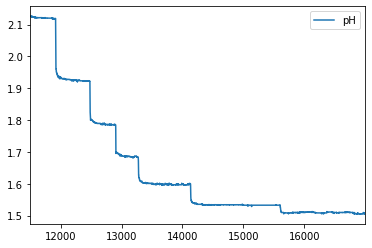

In [5]:
external_steps[11500:17000].plot(y='pH')

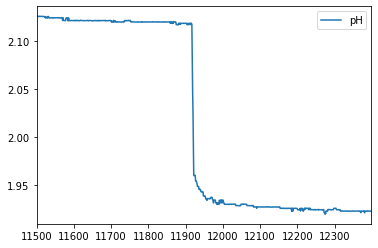

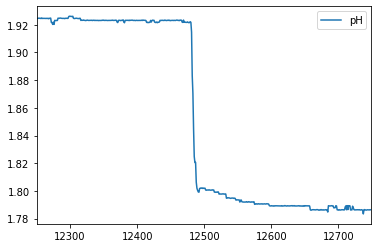

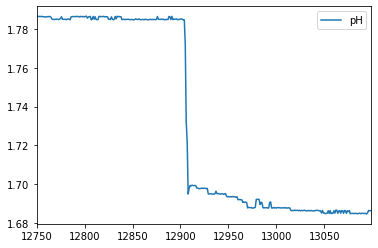

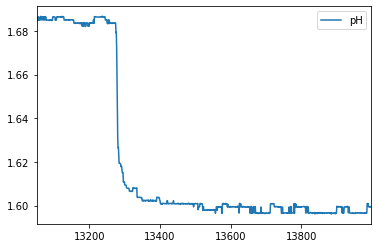

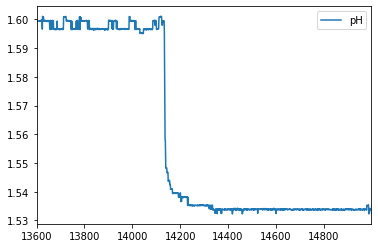

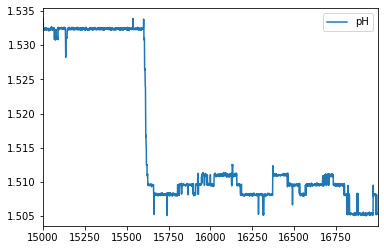

In [6]:
spans=[[11500,12400],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]

for period in spans:
    external_steps[period[0]:period[1]].plot(y = 'pH')

[-47.515583511882646, 3.9245117009927006, 416.78474231457176, 132.19832296051175] [0.19357909629770706, 4.837682972558739, 416.6387350298911, 11.878778747922723]
[-22.069344814008357, 3.5833164101651276, 230.64373062601624, 83.8248480898122] [0.13276586845331081, 3.9654569231592696, 230.64001371818844, 12.076628450694304]
[-12.103347518113797, 1.7880490157314235, 154.6466905938513, 61.009306942062075] [0.09607773682520475, 1.9488408895873126, 154.6337919946077, 12.214604483221093]
[-8.651484597112312, 9.414695741259775, 223.6722129308909, 48.409060741689316] [0.0855604876848244, 10.562993318306019, 223.38615036313527, 12.315075207664492]
[-5.381493275416556, 7.448626665635574, 532.2111701338807, 39.61557058699814] [0.06342695504825752, 8.246973617125587, 531.9999983961249, 12.402139793977192]
[-1.785651878472138, 8.11859542737647, 605.8788690414221, 34.067006460950466] [0.023385431765959523, 8.193391455622942, 605.9131785360994, 12.467666217613894]


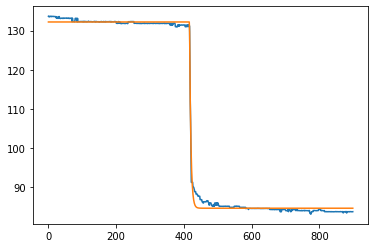

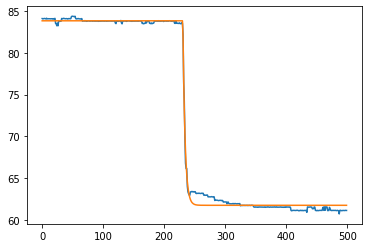

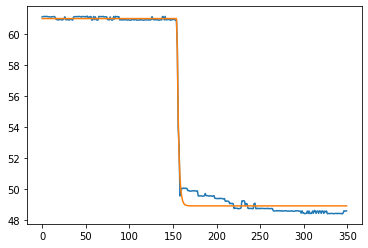

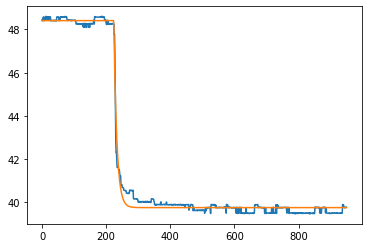

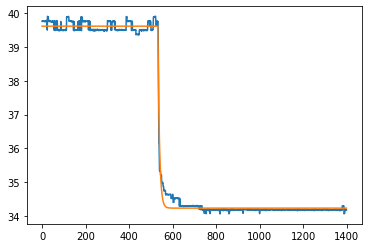

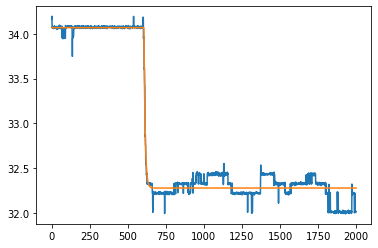

In [21]:
ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

for span in spans:
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(ph_set)
    poh_delogged_set = 10**(poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K, tau, theta, y0], _ = scipy.optimize.curve_fit(fopdt, time_set, 
                                                      ph_delogged_set, [-20, 4, 200, 50])
    
    [K2, tau2, theta2, y02], _ = scipy.optimize.curve_fit(fopdt, time_set, 
                                                      poh_set, [20, 4, 200, 50])

    print([K, tau, theta, y0], [K2, tau2, theta2, y02])
#     print( fopdt(numpy.array(h.t[lower:upper])-h.t[lower], K, tau, theta, y0))
    
# #     plt.plot(h.t, h.logdict['T1'])
#     plt.plot(h.t[lower:upper], fopdt(numpy.array(h.t[lower:upper])-h.t[lower], K, tau, theta, y0))

#     figure = plt.figure()

#     plt.plot(time_set, poh_set)
#     plt.plot(fopdt(time_set, K2, tau2, theta2, y02))    
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(fopdt(time_set, K, tau, theta, y0))


In [ ]:
for time, ph in zip(time_list, ph_delogged):
    figure = plt.figure()
    plt.plot(time, ph)
    plt.plot(fopdt(time))

In [8]:
poh_list

[array([11.874003, 11.874345, 11.874214, 11.87443 , 11.874076, 11.874248,
        11.874079, 11.87412 , 11.873998, 11.874324, 11.874232, 11.874207,
        11.874099, 11.874159, 11.874053, 11.87418 , 11.874196, 11.874313,
        11.874228, 11.874242, 11.874264, 11.874439, 11.874283, 11.875164,
        11.875708, 11.874425, 11.875646, 11.87569 , 11.875768, 11.875765,
        11.874313, 11.875414, 11.87426 , 11.875628, 11.875738, 11.875889,
        11.87582 , 11.875648, 11.875699, 11.875536, 11.875474, 11.875696,
        11.875678, 11.875871, 11.875639, 11.875701, 11.87543 , 11.875669,
        11.875722, 11.875575, 11.875582, 11.87552 , 11.875664, 11.875536,
        11.875722, 11.875506, 11.875634, 11.875533, 11.875751, 11.875586,
        11.875472, 11.875843, 11.875747, 11.875781, 11.875832, 11.875708,
        11.875657, 11.875483, 11.875612, 11.875577, 11.878595, 11.875637,
        11.878347, 11.878404, 11.878446, 11.878514, 11.878487, 11.878487,
        11.87867 , 11.875836, 11.87571